In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

from py_wake.flow_map import Points

from py_wake.wind_turbines._wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake import HorizontalGrid
from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear

In [2]:
# Define constants

D = 100 # Rotor diameter [m]
zh = 100 # Hub height [m]

s = 10 # Turbine spacing [D]
x_turb_no = 5  # No. of turbines in streamwise direction [-]
y_turb_no = 20 # No. of turbines in transverse direction [-]

ws = 10 # Wind speed [m/s]
wd = 270 # Wind direction [deg]
ti0 = np.mean([0.09, 0.1, 0.11, 0.12, 0.14, 0.15, 0.16, 0.17, 0.18]) # Turbulence intensity [-]

In [3]:
# Define wind turbine object

u = np.arange(0, 25.5, .5) # [m/s]

po = [0, 0, 0, 0, 5, 15, 37, 73, 122, 183, 259, 357, 477, 622, 791, 988, 1212, 1469, 1755, 2009, 2176, 2298, 2388, 2447, 2485, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 0] # [kW]
ct = 0.8 * np.ones_like([0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0]) # [-]
      # 1 value for flow_map

wt1 = WindTurbine(name="Ørsted1", diameter=D, hub_height=zh, powerCtFunction=PowerCtTabular(u, po, 'kw', ct))

In [4]:
# Initialize flow model

y, x = [v.flatten().astype(int) for v in np.meshgrid(np.arange(y_turb_no) * D * s, np.arange(x_turb_no) * D * s)]

site = UniformSite(shear=PowerShear(h_ref=zh, alpha=.1))
wfm = PropagateDownwind(site, wt1, wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True), superpositionModel=LinearSum())
sim = wfm(x, y, ws=ws, wd=wd, TI=ti0)

In [6]:
# Calculate mean wind speed

d_downstream = [50, 150, 300]  # Downstream distances [Diameters]
m_downstream = [d * D for d in d_downstream]  # % [m]

w_meas = 5000  # +- Measurement width [m]

# Initialize
y_meas = np.linspace(min(y) - w_meas, max(y) + w_meas, max(y) + 2*w_meas, endpoint=False)
y_meas = np.tile(y_meas, (len(m_downstream), 1)).T  # Shape: (num_y_points, len(m_downstream))

ws_meas = np.zeros((y_meas.shape[0], len(m_downstream)))

ws_min = np.zeros(len(m_downstream))
ws_deficit_max = np.zeros(len(m_downstream))

y_wake = []
ws_wake = []

threshold_values = []
y_plateau = []

# Loop through each measurement distance
for i, m in enumerate(m_downstream):
    x_meas = np.full(y_meas.shape[0], max(x) + m)  # Offset m by max(x) for each y_meas row
    
    ws_meas[:, i] = np.squeeze(
        sim.flow_map(Points(
            x=x_meas,
            y=y_meas[:, i],
            h=zh * np.ones_like(y_meas[:, i])
        )).WS_eff.values)

    # Minimum wind speed, and maximum deficit
    ws_min[i] = np.min(ws_meas[:, i])
    ws_deficit_max[i] = ws - ws_min[i]
    
    # Identify plateau start and end
    threshold = ws_min[i] + 0.05 * ws_deficit_max[i]
    threshold_values.append(threshold)

    below_thresh = np.where(ws_meas[:, i] <= threshold)[0]

    if below_thresh.size > 0:
        pl_start = below_thresh[0]
        pl_end = below_thresh[-1]

        y_plateau.append(y_meas[pl_start:pl_end+1, i])

    # Ifentify wake width and wind speed across it
    y_wake.append(y_meas[np.round(ws_meas[:, i], 3) < ws, i])
    ws_wake.append(ws_meas[np.round(ws_meas[:, i], 3) < ws, i])

    print(f'Wake width at {m/D:.0f} D:  {max(y_wake[i]) - min(y_wake[i]):.0f} m')

# Calculate the average wind speed only in the y_plateau interval
ws_meas_avg = np.array([np.mean(ws_meas[np.isin(y_meas[:, i], y_plateau[i]), i]) for i in range(len(m_downstream))])

Wake width at 50 D:  20992 m
Wake width at 150 D:  22642 m
Wake width at 300 D:  24772 m


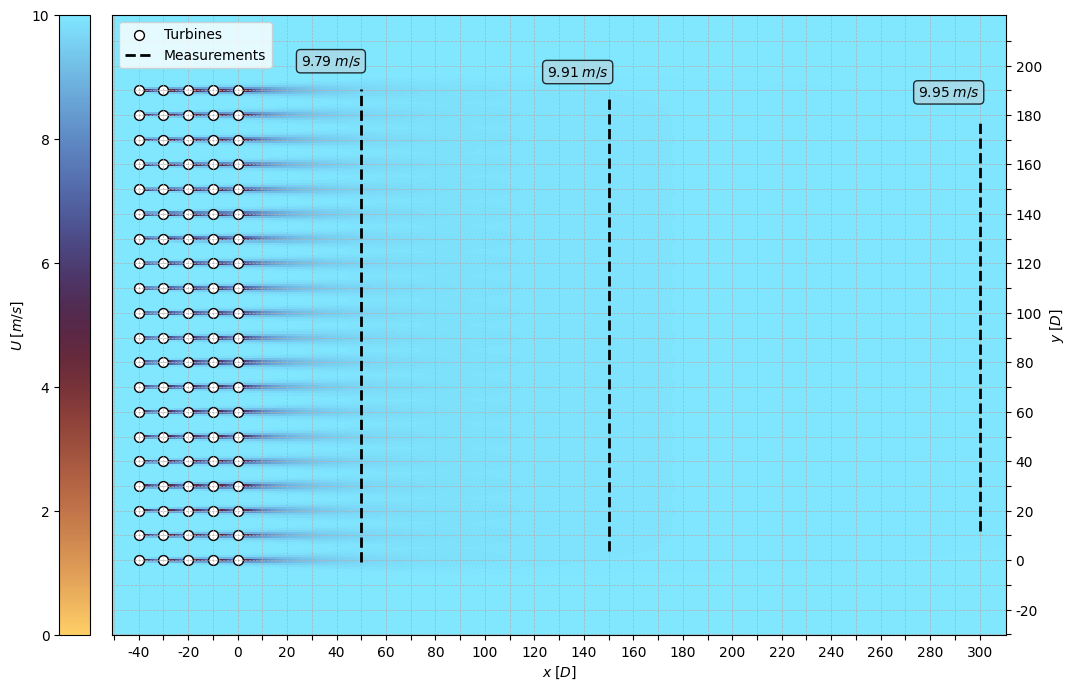

In [32]:
# Visualize farm wake

fig, ax = plt.subplots(figsize=(12, 7))

ext_x = 1*s*D
ext_y = 3*s*D

# Compute the flow map and grid
flow_map_grid = HorizontalGrid(x=np.linspace(min(x)-ext_x, max(x)+m+ext_x, 300), y=np.linspace(min(y)-ext_y, max(y)+ext_y, 300))
flow_map = sim.flow_map(grid=flow_map_grid)
wake_map = flow_map.sel(wd=wd, ws=ws, method="nearest")

wake_map.WS_eff.plot(ax=ax, cmap="managua", vmin=0, vmax=ws, cbar_kwargs={'label': r'$U \; [m/s]$', 'location': 'left', "pad": 0.02})

# Plot turbine positions
ax.scatter(x, y, color="white", marker="o", s=50, label="Turbines", edgecolor="black", linewidth=1)

# Plot measurement planes for each x_meas
for i, m in enumerate(m_downstream):
    x_meas = max(x) + m
    ax.vlines(x=x_meas, ymin=min(y_plateau[i]), ymax=max(y_plateau[i]), color='black', linestyle='dashed', linewidth=2)

    # Second line with variables (still supported inside {})
    plt.text(
        x_meas,
        max(y_plateau[i]) + 800,  # Adjust for second line
        fr'${ws_meas_avg[i]:.2f} \; m/s$',  # Regular string (non-LaTeX)
        ha='right',
        va='bottom',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    )

# "Grouped" legend entry for measurement planes
ax.vlines([], [], [], color='black', linestyle='dashed', linewidth=2, label="Measurements")

# Add axis labels
ax.set_title("")
ax.set_xlabel(r"$x \; [D]$")
ax.set_ylabel(r"$y \; [D]$")
ax.set_aspect('equal')
ax.legend(loc='upper left')

# Add grid with ticklines
xticks = np.arange(max(x) - np.floor(x_turb_no * s * D / 1000) * 1000, max(x) + m + ext_x, 1000)
yticks = np.arange(min(y) - np.floor(ext_y / 1000) * 1000, max(y) + ext_y, 1000)

# Set all ticks (for gridlines)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Show labels every 4th tick in units of D, starting at 0
xtick_labels = [
    f"{(val - max(x)) / D:.0f}" if ((val - max(x)) / D) % 4 == 0 else ""
    for val in xticks
]
ytick_labels = [
    f"{val / D:.0f}" if (val / D) % 4 == 0 else ""
    for val in yticks
]

ax.set_xticklabels(xtick_labels)
ax.set_yticklabels(ytick_labels)

# Force gridlines to show at all tick positions
ax.grid(True, which='major', linestyle='--', linewidth=0.5)

# Set y-axis on the right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

plt.tight_layout()

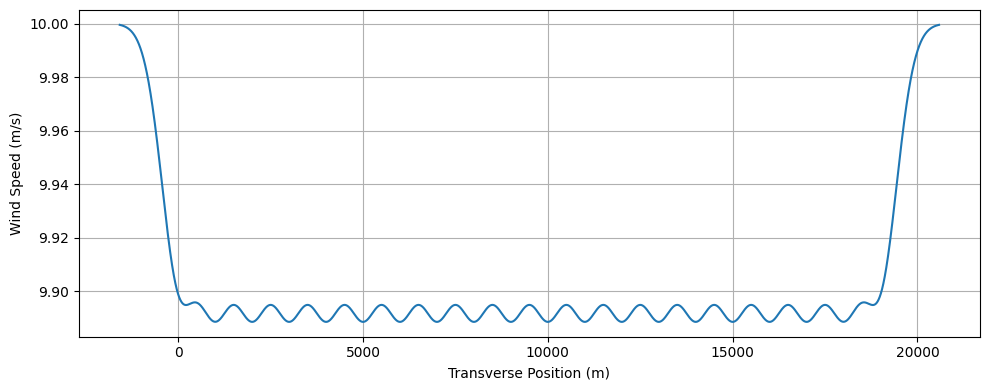

In [7]:
# Plot ws_wake as a function of y_wake
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(y_wake[i], ws_wake[i])

# Add labels, legend, and grid
ax.set_xlabel('Transverse Position (m)')
ax.set_ylabel('Wind Speed (m/s)')
ax.grid(True)

plt.tight_layout()
plt.show()

TypeError: 'Axes' object is not iterable

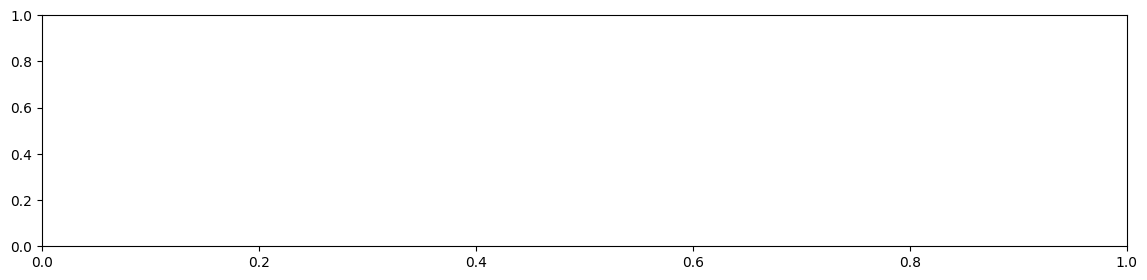

In [8]:
# Plot velocity profiles in a single figure with subplots

# Share x-axis
fig, axes = plt.subplots(len(m_downstream), 1, figsize=(14, 3 * len(m_downstream)), sharex=True)

for i, (m, ax) in enumerate(zip(m_downstream, axes)):

    print(f'Plateau width at {m/max(x):.0f} PL:  {max(y_plateau[i])-min(y_plateau[i]):.0f} m')

    lambda_w = (max(y_plateau[i]) + ((max(y_wake[i]) - max(y_plateau[i])) / 2)) / 2
    print(lambda_w)

    # Plot the velocity profile (wake region)
    ax.plot(y_wake[i], ws_wake[i], label=f'Velocity profile')

    # Plateau function fit
    p_c = max(y) / 2                       # Wake center
    p_w = 6843.7 * (m/max(x))**(0.0105)    # Wake width
    p_s = 0.0185 * (m/max(x))**(-1.029)    # Sharpness of transition
    A = max(ws_wake[i]) - min(ws_wake[i])  # Scale to wake magnitude
    
    U_y = A * 1 / ((np.exp(p_s * (y_wake[i] - p_c - p_w)) + 1) * (np.exp(p_s * (-y_wake[i] + p_c - p_w)) + 1))

    ax.plot(y_wake[i], ws - U_y, color='green', linestyle='dashed', label='Plateau function')

    # Plot y_plateau ws-averaging region
    ax.add_patch(plt.Rectangle((min(y_plateau[i]), ws_min[i]), 
                                max(y_plateau[i]) - min(y_plateau[i]), 
                                threshold_values[i] - ws_min[i], 
                                edgecolor='red', facecolor='red', alpha=0.2, 
                                linewidth=2, label='Plateau region'))

    # Plot labels etc.
    ax.set_ylabel('Wind Speed (m/s)')
    ax.legend(loc="lower left")
    ax.grid(True)

    ax.text(0.01, 0.55, f'{m / max(x):.0f} PL downstream', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))

    # Plot limits
    ax.set_xlim(min(y_wake[i]), max(y_wake[i]))
    ax.set_ylim(0.9975 * min(min(ws_wake[i]), min(ws - U_y)), 1.0025 * max(max(ws_wake[i]), max(ws - U_y)))

# Add a shared x-axis label
axes[0].xaxis.set_label_position('top')
axes[0].set_xlabel('Transverse Position (m)')

axes[0].xaxis.set_ticks_position('top')  # Moves ticks to the top
axes[0].spines['top'].set_visible(True)  # Ensures the top spine is visible

axes[-1].set_xlabel('Transverse Position (m)')

# Add a grouped title for the entire figure
#fig.suptitle('Velocity Profile and Fitted Function', fontsize=20)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.25, 1, 0.975])  # Adjust rect to reduce whitespace below the title
plt.show()
